## Image Caption Generator
Image caption generator is a model which generates caption based on the features present in the input image.

## Introduction
The basic working of the project is that the features are extracted from the images using pre-trained VGG16 model and then fed to the LSTM model along with the captions to train. The trained model is then capable of generating captions for any images that are fed to it.

## Dataset
The dataset used here is the **[FLICKR 8K](https://forms.illinois.edu/sec/1713398)** which consists of around 8091 images along with 5 captions for each images. 
If we have a powerful system with more than 16 GB RAM and a graphic card with more than 4 GB of memory, we can try to take **[FLICKR 30K](http://web.engr.illinois.edu/~bplumme2/Flickr30kEntities/)** which has around 30,000 images with captions.

## Dependencies
* Keras
* Tensorflow GPU
* Pre-trained VGG-16 weights
* NLTK
* Matplotlib

## Steps to follow:

### Importing the required libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

C:\Users\vkhanna\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


python 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
keras version 2.2.4
tensorflow version 1.12.0


## Configuring the GPU memory to be used for training purposes

In [2]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95 #Using 95% of the available memory of the GPU
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

def set_seed(sd=144):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

## Importing the image dataset and its respective captions

In [3]:
## The location of the Flickr8K_ images
dir_Flickr_jpg = "dataset/Flickr8k_images/"
## The location of the caption file
dir_Flickr_text = "dataset/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [4]:
#Finding the captions for each image.
file = open(dir_Flickr_text,'r', encoding='utf8')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splitting the caption dataset at the required position
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])

The number of unique file names : 8092
The distribution of the number of captions for each image:
                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


## Plotting few images and their captions from the dataset

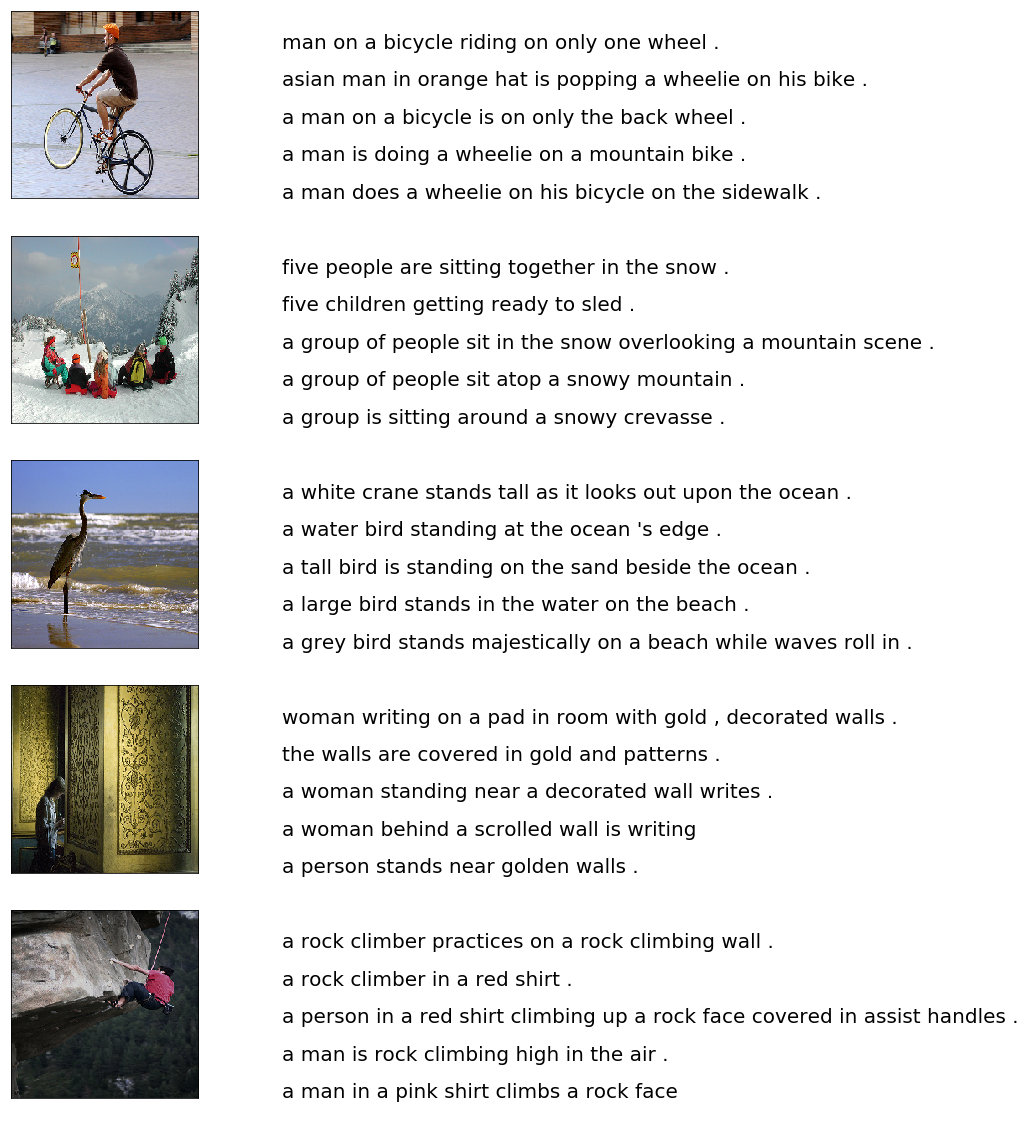

In [5]:
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image

npic = 5 # Displaying 5 images from the dataset
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[-5:]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

## Cleaning captions for further analysis

In [6]:
# Defining a function to calculate the top 5 words in all the captions available for the images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(5)

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975
3,the,18419
4,on,10744


## Cleaning the captions for further processing
The caption dataset contains punctuations, singular words and numerical values that need to be cleaned before it is fed to the model because uncleaned dataset will not create good captionsfor the images

In [8]:
import string

print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)



print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)


print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)



Remove punctuations..

Remove a single character word..

Remove words with numeric values..


In [9]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

## Plotting the top 50 words that appear in the cleaned dataset

Vocabulary Size: 8763


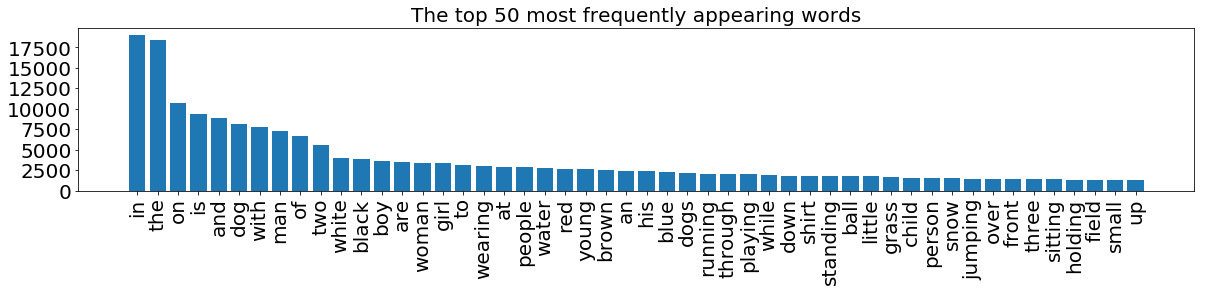

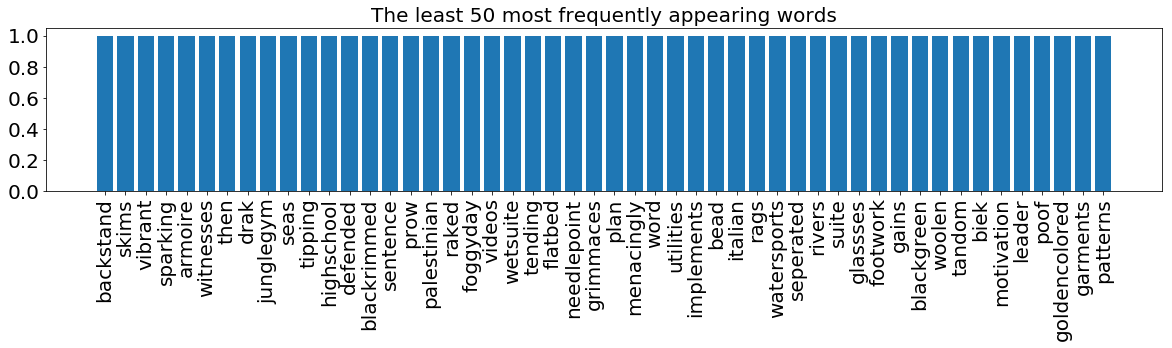

In [10]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

## Adding start and end sequence tokens for each captions 
Start and end sequence has to be added to the tokens so that it is easier to identify the captions for the images as each of them are of different length

In [11]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [12]:
df_txt0[:5]
df_txt0.to_csv("captions_processed.csv")

## Loading VGG16 model and weights to extract features from the images
The pre-trained weights for the VGG-16 model can be downloaded from [here](https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5).

In [19]:
from keras.applications import VGG16

modelvgg = VGG16(include_top=True,weights=None)
## load the locally saved weights 
modelvgg.load_weights("model/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Deleting the last layer of the model 
The last layer of the VGG-16 is excluded here because we are are just using it for extracting the features rather than using for object classification.

In [0]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
## show the deep learning model
modelvgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Feature extraction
Here the features are extracted from all the images in the dataset. VGG-16 model gives out 4096 features from the input image of size 224 * 224

In [13]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
from tqdm import tqdm



In [0]:
images = OrderedDict()
in_layer = Input(shape=(224, 224, 3))
model = VGG16(include_top=False, input_tensor=in_layer)
#print(model.summary())
# extract features from each photo
features = dict()
jpgs = listdir(directory)
for name in tqdm.tqdm(jpgs):
    # load an image from file
    filename = directory + '/' + name
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    #print(image.shape)
    # reshape data for the model
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
    #print(image.shape)
    # prepare the image for the VGG model
    image = preprocess_input(image)
    #print(image.shape)
    # get features
    feature = model.predict(image, verbose=0)
    #print(feature.shape)
    feature = feature.reshape((7,7,512))
    #print(feature.shape)
    # get image id
    image_id = name.split('.')[0]
    # store feature
    images[image_id] = feature

  0%|                                                                                         | 0/8091 [00:00<?, ?it/s]

(224, 224, 3)
(224, 224, 3)
(1, 4096)


In [14]:
import pickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [0]:
save_obj(images,"vgg16_image_features")

In [15]:
images = load_obj('features-rnd')
print('Extracted Features: %d' %len(images))

Extracted Features: 8091


In [23]:
len(images.keys())

8091

## Merging the images and the captions for training

In [16]:
dimages, keepindex = [],[]
# Creating a datframe where only first caption is taken for processing
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    fnm = fnm.replace('.jpg','')
    #print(fnm)
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

#fnames are the names of the image files        
fnames = df_txt0["filename"].iloc[keepindex].values
#dcaptions are the captions of the images 
dcaptions = df_txt0["caption"].iloc[keepindex].values
#dimages are the actual features of the images
dimages = np.array(dimages)
cap = df_txt0["caption"].values

In [17]:
dimages.shape

(8091, 7, 7, 512)

In [18]:
df_txt0[:5]
cap[:5]

array(['startseq  child in pink dress is climbing up set of stairs in an entry way endseq',
       'startseq  black dog and spotted dog are fighting endseq',
       'startseq  little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
       'startseq  man lays on bench while his dog sits by him endseq',
       'startseq  man in an orange hat starring at something endseq'],
      dtype=object)

## Tokenizing the captions for further processing
As the model can't take texts as an input, they need to converted into vectors.

In [19]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


## Splitting the training and test data

In [20]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

## Finding the max length of the caption

In [21]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


## Processing the captions and images as per the required shape by the model

In [22]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to 

            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    Ximage = Ximage.reshape(Ximage.shape[0],7,7,512)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 4855
 (49631, 30) (49631, 7, 7, 512) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 7, 7, 512) (16353, 4476)


In [23]:
#Ximage_train = Ximage_train.reshape(49631,7,7,512)
print(Ximage_train.shape)

#Ximage_val = Ximage_val.reshape(16353,7,7,512)
print(Ximage_val.shape)

(49631, 7, 7, 512)
(16353, 7, 7, 512)


## Building the LSTM model

In [24]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, Input, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate

def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalAveragePooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

fe_avg_pool_model = define_model(vocab_size,maxlen)
fe_avg_pool_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 50)       223800      input_2[0][0]                    
__________________________________________________________________________________________________
dense (Den

## Training the LSTM model

In [25]:
# fit model
from time import time

#start = time.time()
hist = fe_avg_pool_model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=15, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
#end = time.time()
#print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Train on 49631 samples, validate on 16353 samples
Epoch 1/15
 - 1208s - loss: 5.4203 - acc: 0.1512 - val_loss: 5.0501 - val_acc: 0.1679
Epoch 2/15
 - 1060s - loss: 4.7164 - acc: 0.1952 - val_loss: 4.7053 - val_acc: 0.2305
Epoch 3/15
 - 753s - loss: 4.2410 - acc: 0.2391 - val_loss: 4.4936 - val_acc: 0.2471
Epoch 4/15
 - 978s - loss: 3.9293 - acc: 0.2636 - val_loss: 4.4521 - val_acc: 0.2603
Epoch 5/15
 - 1197s - loss: 3.6919 - acc: 0.2804 - val_loss: 4.3750 - val_acc: 0.2664
Epoch 6/15
 - 972s - loss: 3.4858 - acc: 0.2967 - val_loss: 4.3596 - val_acc: 0.2768
Epoch 7/15


KeyboardInterrupt: 

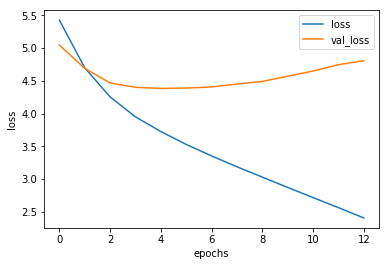

In [30]:
fe_avg_pool_model.save("lstm_18_4_3pm.h5")

for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Generating captions on a small set of images
After the model finishes training we can test out its performance on the some of the test images to figure out if the generated captions are good enough. If the generated captions are good enough we can generate the captions for the whole test dataset.

In [26]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
import pickle

with open('filename.pickle', 'wb') as handle:
    pickle.dump(index_word, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [27]:
fe_avg_pool_model.load_weights("lstm_18_4_3pm.h5")

File Name :  1024138940_f1fefbdce1.jpg
startseq two dogs are standing on the beach endseq
File Name :  102455176_5f8ead62d5.jpg
startseq man in flannel snowboarding endseq
File Name :  1026685415_0431cbf574.jpg
startseq black dog digging through the woods endseq
File Name :  1028205764_7e8df9a2ea.jpg
startseq child and woman are jumping into the pool endseq
File Name :  1030985833_b0902ea560.jpg
startseq black dog is playing with blue hind ball endseq


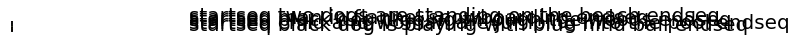

In [32]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = fe_avg_pool_model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 512
npix = 7
target_size = (npix,npix,512)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[20:25],di_test[20:25]):
    ## images 
    print("File Name : ",jpgfnm)
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature),len(image_feature),512))
    print(caption)
    ax = fig.add_subplot(512,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

## Evaluating the model performance
After the model is trained we have to test the models prediction capabilities on test dataset. Traditional accuracy metric can't be used on predictions. For text evaluations we have a metric called as [BLEU Score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/). BLEU stands for Bilingual Evaluation Understudy, it is a score for comparing a candidate text to one or more reference text.

Example:

In [33]:
hypothesis = "I like dog"
hypothesis = hypothesis.split()
reference  = "I do like dog"
references = [reference.split()] ## references must be a list containing list. 

In [34]:
from nltk.translate.bleu_score import sentence_bleu
print("BLEU={:4.3f}".format(sentence_bleu(references,hypothesis)))

BLEU=0.000


In [36]:
hypothesis2 = "I love dog!".split()
print("BLEU={:4.3f}".format(sentence_bleu(references,  hypothesis2))) 

BLEU=0.544


## Generating captions for the whole test data and finding BLEU score

In [40]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature),len(image_feature),512))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


In [41]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.350


## Good and bad captions examples from the model
We can check out some of the generated caption's quality. Some times due to the complex nature of the images the generated captions are not acceptable. Below you would find some examples

In [43]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        print("Good Caption")
plot_images(pred_good)+= 1
plt.show()

print("Bad Caption")
plot_images(pred_bad)


SyntaxError: ignored

In [0]:
print("Good Caption")
plot_images(pred_good)

Good Caption


NameError: name 'plot_images' is not defined

## Conclusion
The model has been successfully trained to generate the captions as expected for the images. The caption generation has constantly been improved by fine tuning the model with different hyper parameter. Higher BLEU score indicates that the generated captions are very similar to those of the actual caption present on the images. Below you will find a table displaying different BLEU scores obtained by tuning the parameters:

![](images/table.png?raw=true)

With the help of Tensorboard, we were able to see how different training process had an impact on the model. 

![](images/tensorboard.PNG?raw=true)

The validation loss falls upto 5th epoch and then increases afterwards, while the training loss still continues falling

The following were the major outcomes and aboservations of the training process and testing the model on the test data:
* The validation loss increases after 5th epoch in most cases even though the training loss decreases over time. This indicates that the model is over fitting and the training needs to stop.
* Higher BLEU score doesn't aways translate to better generated captions. If the model overfits on your training data, it will lead the model to go through details in the image and generate out captions which don't make sense. It can be seen in the good and the bad captions generated above.